<a href="https://colab.research.google.com/github/Kitichart/creditcard/blob/main/Approaching_(Almost)_Any_NLP_Problem_on_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 4.3 MB/s 
     |████████████████████████████████| 6.6 MB 44.9 MB/s 
     |████████████████████████████████| 596 kB 59.4 MB/s 
     |████████████████████████████████| 84 kB 4.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# Loading Dependencies
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import transformers

from tokenizers import BertWordPieceTokenizer

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [ ]:
import torch
torch.cuda.is_available()
# Output would be True if Pytorch is using GPU otherwise it would be False.

True

In [ ]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [ ]:
df = pd.read_csv('/content/label_csr.csv')

In [ ]:
from sklearn.utils import resample
#create two different dataframe of majority and minority class 
df_majority = df[(df['class_num']==1)] 
df_minor1 = df[(df['class_num']==2)] 
df_minor2 = df[(df['class_num']==3)] 
df_minor3 = df[(df['class_num']==4)] 
# upsample minority class
df_minority_upsampled = resample(df_minor1, 
                                 replace=True,    # sample with replacement
                                 n_samples= 2483, # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])

df_minority_upsampled = resample(df_minor2, 
                                 replace=True,    # sample with replacement
                                 n_samples= 2483, # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_upsampled])

df_minority_upsampled = resample(df_minor3, 
                                 replace=True,    # sample with replacement
                                 n_samples= 2483, # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_upsampled])

df = df_upsampled

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [ ]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(df['class'].values)

In [ ]:
xtrain, xvalid, ytrain, yvalid = train_test_split(df['sentence'].values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

In [ ]:
print (xtrain.shape)
print (xvalid.shape)

(8938,)
(994,)


In [ ]:
# Always start with these features. They work (almost) everytime!
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

Test set preparation

In [ ]:
test_set = pd.read_csv('/content/test_set_csr.csv')

In [ ]:
y_test = lbl_enc.fit_transform(test_set['class'].values)

In [ ]:
x_test_tfv = tfv.transform(test_set['sentence'].values)

In [ ]:
x_test = test_set['sentence'].values

Word Embedding

Glove

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('/content/glove.6B.300d.txt')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

nltk.download('punkt')

# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in tqdm(xtrain)]
xvalid_glove = [sent2vec(x) for x in tqdm(xvalid)]
x_test_glove = [sent2vec(x) for x in tqdm(x_test)]

xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)
x_test_glove = np.array(x_test_glove)

--2022-05-22 04:50:35--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-05-22 04:50:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-05-22 04:50:36--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

400000it [00:22, 17760.90it/s]


Found 400000 word vectors.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


100%|██████████| 1949/1949 [00:00<00:00, 4052.80it/s]


In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!unzip wiki-news-300d-1M.vec.zip

--2022-05-22 04:54:03--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  44.3MB/s    in 16s     

2022-05-22 04:54:19 (41.9 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


Keras tokenizer

In [ ]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(xtrain) + list(xvalid) + list(x_test))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)
x_test_seq = token.texts_to_sequences(x_test)

# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)
x_test_pad = sequence.pad_sequences(x_test_seq, maxlen=max_len)

word_index = token.word_index

# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 6553/6553 [00:00<00:00, 377052.94it/s]


Fasttext

In [ ]:
from keras.preprocessing.text import Tokenizer

In [ ]:
'''## some config values 
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a question to use

EMBEDDING_FILE = '/content/wiki-news-300d-1M.vec'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = token.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    #if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector'''

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


IndexError: ignored

In [ ]:
'''embeddings_index = {}
f = codecs.open('../input/fasttext/wiki.simple.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))'''

BASELINE

Logistic Resgression + Keras + Glove

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score

In [ ]:
# Fitting a simple Logistic Regression on Keras + Glove
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_pad, ytrain)
predictions = clf.predict_proba(xvalid_pad)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 1.163 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
predict_class_test = clf.predict(x_test_pad)
predictions = clf.predict_proba(x_test_pad)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, predict_class_test, average='weighted')
print('Logistic Resgression + Keras + Glove\nPrecision =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[0])
print('Recall =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[1])
print('F1 Score =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[2])
print('Accuracy Score =',accuracy_score(y_test, predict_class_test))
print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions))

Logistic Resgression + Keras + Glove
Precision = 0.679645285913478
Recall = 0.5874807593637763
F1 Score = 0.6272914177858718
Accuracy Score = 0.5874807593637763
logloss: 1.467 


Logistic Resgression + Glove

In [ ]:
# Fitting a simple Logistic Regression on Glove
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_glove, ytrain)
predictions = clf.predict_proba(xvalid_glove)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.343 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
predict_class_test = clf.predict(x_test_glove)
predictions = clf.predict_proba(x_test_glove)

In [ ]:
precision_recall_fscore_support(y_test, predict_class_test, average='weighted')
print('Logistic Resgression + Glove\nPrecision =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[0])
print('Recall =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[1])
print('F1 Score =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[2])
print('Accuracy Score =',accuracy_score(y_test, predict_class_test))
print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions))

Logistic Resgression + Glove
Precision = 0.8431889747900113
Recall = 0.7824525397639815
F1 Score = 0.8026175225686256
Accuracy Score = 0.7824525397639815
logloss: 0.651 


[Text(0, 0.5, 'Course'),
 Text(0, 1.5, 'Assignment'),
 Text(0, 2.5, 'Instructor'),
 Text(0, 3.5, 'Other')]

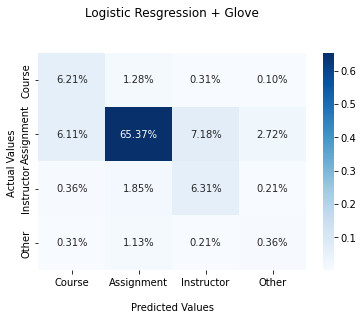

In [ ]:
cf_matrix = confusion_matrix(y_test, predict_class_test)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Logistic Resgression + Glove\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Course','Assignment','Instructor','Other'])
ax.yaxis.set_ticklabels(['Course','Assignment','Instructor','Other'])

## Display the visualization of the Confusion Matrix.
#plt.show()

Logistic Resgression + TF-IDF

In [ ]:
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.194 


In [ ]:
predict_class = clf.predict(xvalid_tfv)

In [ ]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(yvalid, predict_class)

print(cf_matrix)

[[249   0   0   0]
 [  6 236   6   0]
 [  0   0 249   0]
 [  0   9   0 239]]


[Text(0, 0.5, 'Course'),
 Text(0, 1.5, 'Assignment'),
 Text(0, 2.5, 'Instructor'),
 Text(0, 3.5, 'Other')]

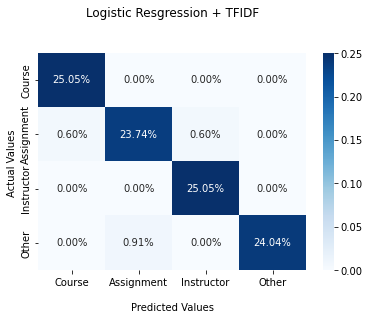

In [ ]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Logistic Resgression + TFIDF\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Course','Assignment','Instructor','Other'])
ax.yaxis.set_ticklabels(['Course','Assignment','Instructor','Other'])

## Display the visualization of the Confusion Matrix.
#plt.show()

In [ ]:
#test
predict_class_test = clf.predict(x_test_tfv)

In [ ]:
predictions = clf.predict_proba(x_test_tfv)

print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions))

logloss: 0.500 


[Text(0, 0.5, 'Course'),
 Text(0, 1.5, 'Assignment'),
 Text(0, 2.5, 'Instructor'),
 Text(0, 3.5, 'Other')]

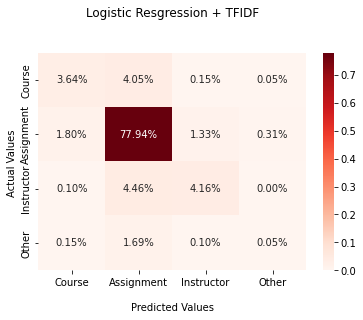

In [ ]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, predict_class_test)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Reds')

ax.set_title('Logistic Resgression + TFIDF\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Course','Assignment','Instructor','Other'])
ax.yaxis.set_ticklabels(['Course','Assignment','Instructor','Other'])

## Display the visualization of the Confusion Matrix.
#plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, predict_class_test, average='weighted')
print('Logistic Resgression + TFIDF\nPrecision =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[0])
print('Recall =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[1])
print('F1 Score =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[2])
print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions))

Logistic Resgression + TFIDF
Precision = 0.8356161134017722
Recall = 0.857875833760903
F1 Score = 0.8415358968574578
logloss: 0.500 


Logistic Regression + COUNT

In [ ]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(xtrain) + list(xvalid))
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

In [ ]:
# Fitting a simple Logistic Regression on Counts
clf = LogisticRegression(C=1.0)
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.084 


In [ ]:
x_test = test_set['sentence'].values

In [ ]:
#test
x_test_ctv =  ctv.transform(x_test) 
predict_class_test = clf.predict(x_test_ctv)
predictions = clf.predict_proba(x_test_ctv)

[Text(0, 0.5, 'Course'),
 Text(0, 1.5, 'Assignment'),
 Text(0, 2.5, 'Instructor'),
 Text(0, 3.5, 'Other')]

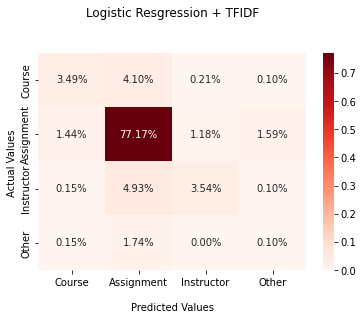

In [ ]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, predict_class_test)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Reds')

ax.set_title('Logistic Resgression + TFIDF\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Course','Assignment','Instructor','Other'])
ax.yaxis.set_ticklabels(['Course','Assignment','Instructor','Other'])

## Display the visualization of the Confusion Matrix.
#plt.show()

In [ ]:
precision_recall_fscore_support(y_test, predict_class_test, average='weighted')
print('Logistic Regression + COUNT\nPrecision =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[0])
print('Recall =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[1])
print('F1 Score =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[2])
print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions))

Logistic Regression + COUNT
Precision = 0.8305001993554317
Recall = 0.8429964084145716
F1 Score = 0.8300275272466815
logloss: 0.513 


NB + TFIDF

In [ ]:
# Fitting a simple Naive Bayes on TFIDF
clf = MultinomialNB()
clf.fit(xtrain_tfv, ytrain)
predictions = clf.predict_proba(xvalid_tfv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.137 


In [ ]:
#test
predict_class_test = clf.predict(x_test_tfv)
predictions = clf.predict_proba(x_test_tfv)

[Text(0, 0.5, 'Course'),
 Text(0, 1.5, 'Assignment'),
 Text(0, 2.5, 'Instructor'),
 Text(0, 3.5, 'Other')]

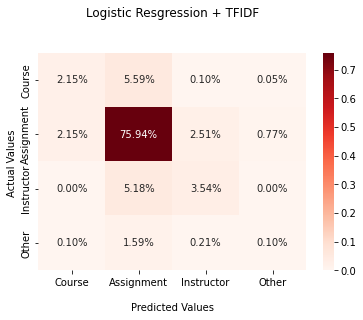

In [ ]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, predict_class_test)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Reds')

ax.set_title('Logistic Resgression + TFIDF\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Course','Assignment','Instructor','Other'])
ax.yaxis.set_ticklabels(['Course','Assignment','Instructor','Other'])

## Display the visualization of the Confusion Matrix.
#plt.show()

In [ ]:
precision_recall_fscore_support(y_test, predict_class_test, average='weighted')
print('NB + TFIDF\nPrecision =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[0])
print('Recall =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[1])
print('F1 Score =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[2])
print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions))

NB + TFIDF
Precision = 0.789145262400417
Recall = 0.8173422267829656
F1 Score = 0.7983660666132
logloss: 0.557 


NB + COUNT

In [ ]:
# Fitting a simple Naive Bayes on Counts
clf = MultinomialNB()
clf.fit(xtrain_ctv, ytrain)
predictions = clf.predict_proba(xvalid_ctv)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.210 


In [ ]:
#test
predict_class_test = clf.predict(x_test_ctv)
predictions = clf.predict_proba(x_test_ctv)

[Text(0, 0.5, 'Course'),
 Text(0, 1.5, 'Assignment'),
 Text(0, 2.5, 'Instructor'),
 Text(0, 3.5, 'Other')]

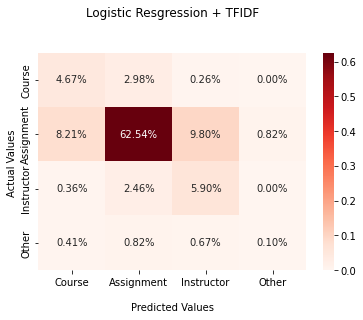

In [ ]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, predict_class_test)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Reds')

ax.set_title('Logistic Resgression + TFIDF\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Course','Assignment','Instructor','Other'])
ax.yaxis.set_ticklabels(['Course','Assignment','Instructor','Other'])

## Display the visualization of the Confusion Matrix.
#plt.show()

In [ ]:
precision_recall_fscore_support(y_test, predict_class_test, average='weighted')
print('NB + Count Vector\nPrecision =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[0])
print('Recall =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[1])
print('F1 Score =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[2])
print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions))

NB + Count Vector
Precision = 0.7999321260730153
Recall = 0.7321703437660338
F1 Score = 0.7540556589686565
logloss: 1.174 


SVM + TFIDF

In [ ]:
# Apply SVD, I chose 120 components. 120-200 components are good enough for SVM model.
svd = decomposition.TruncatedSVD(n_components=120)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xvalid_svd_scl = scl.transform(xvalid_svd)

In [ ]:
# Fitting a simple SVM
clf = SVC(C=1.0, probability=True) # since we need probabilities
clf.fit(xtrain_svd_scl, ytrain)
predictions = clf.predict_proba(xvalid_svd_scl)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.138 


In [ ]:
#test
x_test_svd = svd.transform(x_test_tfv)
x_test_svd_scl = scl.transform(x_test_svd)
predict_class_test = clf.predict(x_test_svd_scl)
predictions = clf.predict_proba(x_test_svd_scl)

[Text(0, 0.5, 'Assignment'),
 Text(0, 1.5, 'Course'),
 Text(0, 2.5, 'Instructor'),
 Text(0, 3.5, 'Other')]

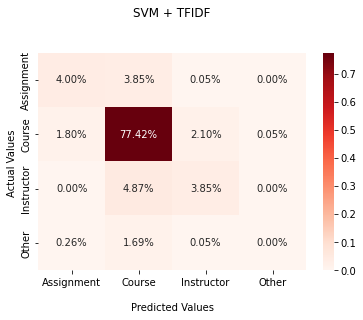

In [ ]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, predict_class_test)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Reds')

ax.set_title('SVM + TFIDF\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Assignment', 'Course','Instructor','Other'])
ax.yaxis.set_ticklabels(['Assignment', 'Course','Instructor','Other'])

## Display the vis

In [ ]:
precision_recall_fscore_support(y_test, predict_class_test, average='weighted')
print('SVM + TFIDF\nPrecision =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[0])
print('Recall =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[1])
print('F1 Score =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[2])
print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions))

SVM + TFIDF
Precision = 0.8249296450425173
Recall = 0.8527449974345819
F1 Score = 0.8354098985417825
logloss: 0.581 


XGBOOST TFIDF

In [ ]:
# Fitting a simple xgboost on tf-idf
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_tfv.tocsc(), ytrain)
predictions = clf.predict_proba(xvalid_tfv.tocsc())

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.091 


In [ ]:
#test

predict_class_test = clf.predict(x_test_tfv.tocsc())
predictions = clf.predict_proba(x_test_tfv.tocsc())

[Text(0, 0.5, 'Assignment'),
 Text(0, 1.5, 'Course'),
 Text(0, 2.5, 'Instructor'),
 Text(0, 3.5, 'Other')]

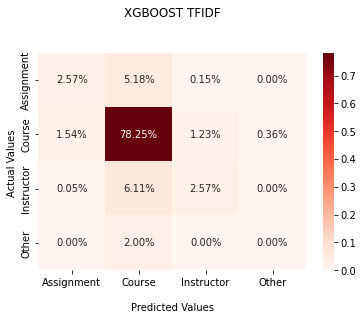

In [ ]:
#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, predict_class_test)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Reds')

ax.set_title('XGBOOST TFIDF\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Assignment', 'Course','Instructor','Other'])
ax.yaxis.set_ticklabels(['Assignment', 'Course','Instructor','Other'])

## Display the vis

In [ ]:
precision_recall_fscore_support(y_test, predict_class_test, average='weighted')
print('XGBOOST TFIDF\nPrecision =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[0])
print('Recall =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[1])
print('F1 Score =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[2])
print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions))

XGBOOST TFIDF
Precision = 0.8010245533503024
Recall = 0.8337609030271934
F1 Score = 0.8054173521275534
logloss: 0.636 


In [ ]:
# Fitting a simple xgboost on CTV
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_ctv.tocsc(), ytrain)
predictions = clf.predict_proba(xvalid_ctv.tocsc())

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.156 


[Text(0, 0.5, 'Assignment'),
 Text(0, 1.5, 'Course'),
 Text(0, 2.5, 'Instructor'),
 Text(0, 3.5, 'Other')]

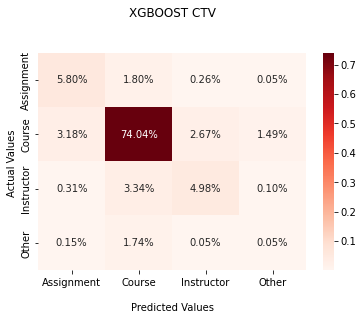

In [ ]:
#test

predict_class_test = clf.predict(x_test_ctv.tocsc())
predictions = clf.predict_proba(x_test_ctv.tocsc())

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, predict_class_test)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Reds')

ax.set_title('XGBOOST CTV\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Assignment', 'Course','Instructor','Other'])
ax.yaxis.set_ticklabels(['Assignment', 'Course','Instructor','Other'])

## Display the vis

In [ ]:
precision_recall_fscore_support(y_test, predict_class_test, average='weighted')
print('XGBOOST CTV\nPrecision =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[0])
print('Recall =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[1])
print('F1 Score =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[2])
print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions))

XGBOOST CTV
Precision = 0.8483223492710489
Recall = 0.8486403283735249
F1 Score = 0.8479407812828104
logloss: 0.510 


XGBOOST TFIDF SVD

In [ ]:
# Fitting a simple xgboost on tf-idf svd features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
clf.fit(xtrain_svd, ytrain)
predictions = clf.predict_proba(xvalid_svd)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.030 


[Text(0, 0.5, 'Assignment'),
 Text(0, 1.5, 'Course'),
 Text(0, 2.5, 'Instructor'),
 Text(0, 3.5, 'Other')]

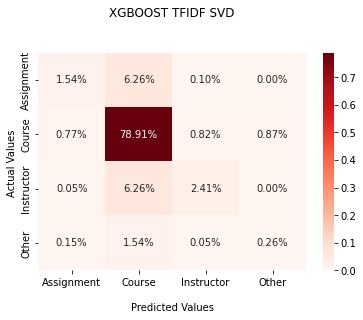

In [ ]:
#test

predict_class_test = clf.predict(x_test_svd)
predictions = clf.predict_proba(x_test_svd)

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, predict_class_test)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Reds')

ax.set_title('XGBOOST TFIDF SVD\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Assignment', 'Course','Instructor','Other'])
ax.yaxis.set_ticklabels(['Assignment', 'Course','Instructor','Other'])

## Display the vis

In [ ]:
precision_recall_fscore_support(y_test, predict_class_test, average='weighted')
print('XGBOOST TFIDF SVD\nPrecision =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[0])
print('Recall =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[1])
print('F1 Score =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[2])
print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions))

XGBOOST TFIDF SVD
Precision = 0.805738506744966
Recall = 0.8311954848640328
F1 Score = 0.798014680336503
logloss: 0.876 


In [ ]:
# Fitting a simple xgboost on tf-idf svd features
clf = xgb.XGBClassifier(nthread=10)
clf.fit(xtrain_svd, ytrain)
predictions = clf.predict_proba(xvalid_svd)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.146 


[Text(0, 0.5, 'Assignment'),
 Text(0, 1.5, 'Course'),
 Text(0, 2.5, 'Instructor'),
 Text(0, 3.5, 'Other')]

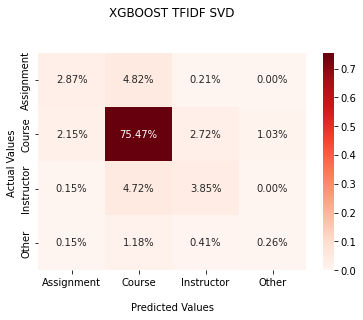

In [ ]:
#test

predict_class_test = clf.predict(x_test_svd)
predictions = clf.predict_proba(x_test_svd)

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, predict_class_test)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Reds')

ax.set_title('XGBOOST TFIDF SVD\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Assignment', 'Course','Instructor','Other'])
ax.yaxis.set_ticklabels(['Assignment', 'Course','Instructor','Other'])

## Display the vis

In [ ]:
precision_recall_fscore_support(y_test, predict_class_test, average='weighted')
print('XGBOOST TFIDF SVD\nPrecision =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[0])
print('Recall =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[1])
print('F1 Score =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[2])
print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions))

XGBOOST TFIDF SVD
Precision = 0.8057919718386625
Recall = 0.8245253976398152
F1 Score = 0.8126562913777737
logloss: 0.570 


Grid Search

In [ ]:
mll_scorer = metrics.make_scorer(multiclass_logloss, greater_is_better=False, needs_proba=True)

In [ ]:
# Initialize SVD
svd = TruncatedSVD()
    
# Initialize the standard scaler 
scl = preprocessing.StandardScaler()

# We will use logistic regression here..
lr_model = LogisticRegression()

# Create the pipeline 
clf = pipeline.Pipeline([('svd', svd),
                         ('scl', scl),
                         ('lr', lr_model)])

In [ ]:
param_grid = {'svd__n_components' : [100, 120 ,140 ,160 ,180 , 200],
              'lr__C': [0.1, 1.0, 10, 100], 
              'lr__penalty': ['l1', 'l2']}

In [ ]:
# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=mll_scorer,
                                 verbose=10, n_jobs=-1, refit=True, cv=2)

# Fit Grid Search Model
model.fit(x_test_tfv, y_test)  # we can use the full data here but im only using xtrain
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 2 folds for each of 48 candidates, totalling 96 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
48 fits failed out of a total of 96.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fil

Best score: -0.557
Best parameters set:
	lr__C: 0.1
	lr__penalty: 'l2'
	svd__n_components: 100


In [ ]:
nb_model = MultinomialNB()

# Create the pipeline 
clf = pipeline.Pipeline([('nb', nb_model)])

# parameter grid
param_grid = {'nb__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=mll_scorer,
                                 verbose=10, n_jobs=-1, refit=True, cv=2)

# Fit Grid Search Model
model.fit(x_test_tfv, y_test)  # we can use the full data here but im only using xtrain. 
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 2 folds for each of 6 candidates, totalling 12 fits
Best score: -0.646
Best parameters set:
	nb__alpha: 10


Word Vectors

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('/content/glove.6B.300d.txt')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

nltk.download('punkt')

# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in tqdm(xtrain)]
xvalid_glove = [sent2vec(x) for x in tqdm(xvalid)]
x_test_glove = [sent2vec(x) for x in tqdm(x_test)]

xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)
x_test_glove = np.array(x_test_glove)

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

In [ ]:
!unzip glove*.zip

In [ ]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('/content/glove.6B.300d.txt')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:22, 17986.56it/s]

Found 400000 word vectors.


In [ ]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# create sentence vectors using the above function for training and validation set
xtrain_glove = [sent2vec(x) for x in tqdm(xtrain)]
xvalid_glove = [sent2vec(x) for x in tqdm(xvalid)]
x_test_glove = [sent2vec(x) for x in tqdm(x_test)]

100%|██████████| 1949/1949 [00:00<00:00, 4326.61it/s]


In [ ]:
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)
x_test_glove = np.array(x_test_glove)

# Fitting a simple xgboost on glove features

In [ ]:
# Fitting a simple xgboost on glove features
clf = xgb.XGBClassifier(nthread=10, silent=False)
clf.fit(xtrain_glove, ytrain)
predictions = clf.predict_proba(xvalid_glove)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.147 


[Text(0, 0.5, 'Assignment'),
 Text(0, 1.5, 'Course'),
 Text(0, 2.5, 'Instructor'),
 Text(0, 3.5, 'Other')]

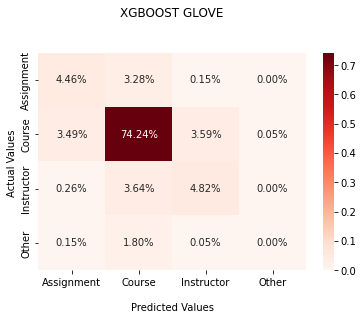

In [ ]:
#test

predict_class_test = clf.predict(x_test_glove)
predictions = clf.predict_proba(x_test_glove)

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, predict_class_test)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Reds')

ax.set_title('XGBOOST GLOVE\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Assignment', 'Course','Instructor','Other'])
ax.yaxis.set_ticklabels(['Assignment', 'Course','Instructor','Other'])

## Display the vis

In [ ]:
precision_recall_fscore_support(y_test, predict_class_test, average='weighted')
print('XGBOOST GLOVE\nPrecision =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[0])
print('Recall =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[1])
print('F1 Score =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[2])
print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions))

XGBOOST GLOVE
Precision = 0.8191762383109302
Recall = 0.8353001539250898
F1 Score = 0.8271326312788227
logloss: 0.495 


Fitting a simple xgboost on glove features

In [ ]:
# Fitting a simple xgboost on glove features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1, silent=False)
clf.fit(xtrain_glove, ytrain)
predictions = clf.predict_proba(xvalid_glove)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.018 


[Text(0, 0.5, 'Assignment'),
 Text(0, 1.5, 'Course'),
 Text(0, 2.5, 'Instructor'),
 Text(0, 3.5, 'Other')]

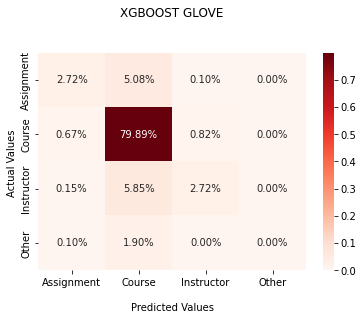

In [ ]:
#test

predict_class_test = clf.predict(x_test_glove)
predictions = clf.predict_proba(x_test_glove)

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, predict_class_test)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Reds')

ax.set_title('XGBOOST GLOVE\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Assignment', 'Course','Instructor','Other'])
ax.yaxis.set_ticklabels(['Assignment', 'Course','Instructor','Other'])

## Display the vis

In [ ]:
precision_recall_fscore_support(y_test, predict_class_test, average='weighted')
print('XGBOOST GLOVE\nPrecision =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[0])
print('Recall =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[1])
print('F1 Score =',precision_recall_fscore_support(y_test, predict_class_test, average='weighted')[2])
print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions))

XGBOOST GLOVE
Precision = 0.8252615159045269
Recall = 0.8532580810672139
F1 Score = 0.8224264249564023
logloss: 0.601 


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Deep Learning

In [ ]:
# scale the data before any neural net:
scl = preprocessing.StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xvalid_glove_scl = scl.transform(xvalid_glove)
x_test_glove_scl = scl.transform(x_test_glove)

In [ ]:
# we need to binarize the labels for the neural net
ytrain_enc = np_utils.to_categorical(ytrain)
yvalid_enc = np_utils.to_categorical(yvalid)
y_test_enc = np_utils.to_categorical(y_test)

In [ ]:
# create a simple 3 layer sequential neural net
model = Sequential()

model.add(Dense(300, input_dim=300, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(4))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model.fit(xtrain_glove_scl, y=ytrain_enc, batch_size=64, 
          epochs=5, verbose=1, 
          validation_data=(xvalid_glove_scl, yvalid_enc))

Epoch 1/5
140/140 [==============================] - 5s 5ms/step - loss: 0.3953 - val_loss: 0.1485
Epoch 2/5
140/140 [==============================] - 1s 4ms/step - loss: 0.1211 - val_loss: 0.0885
Epoch 3/5
140/140 [==============================] - 1s 4ms/step - loss: 0.0761 - val_loss: 0.0989
Epoch 4/5
140/140 [==============================] - 1s 4ms/step - loss: 0.0505 - val_loss: 0.0821
Epoch 5/5
140/140 [==============================] - 1s 4ms/step - loss: 0.0358 - val_loss: 0.0811


In [ ]:
model.summary()
print ("logloss: %0.3f " % multiclass_logloss(yvalid_enc, model.predict(xvalid_glove_scl)))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               90300     
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 batch_normalization (BatchN  (None, 300)              1200      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 300)               90300     
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                        

You need to keep on tuning the parameters of the neural network, add more layers, increase dropout to get better results. Here, I'm just showing that its fast to implement and run and gets better result than xgboost without any optimization :)

To move further, i.e. with LSTMs we need to tokenize the text data

In [ ]:
print ("logloss: %0.3f " % multiclass_logloss(y_test_enc, model.predict(x_test_glove_scl)))

logloss: 0.785 


In [ ]:
model.predict(x_test_glove_scl)

array([[6.9953827e-04, 9.6473390e-01, 3.4385223e-02, 1.8137075e-04],
       [4.7326083e-07, 4.9779988e-05, 9.9993563e-01, 1.4091960e-05],
       [3.7522975e-04, 9.9946207e-01, 1.4022007e-04, 2.2533630e-05],
       ...,
       [2.9467347e-07, 9.9999940e-01, 4.0116544e-07, 1.3225083e-09],
       [1.5130978e-04, 9.9983728e-01, 9.7175407e-06, 1.7381899e-06],
       [2.6460921e-05, 9.6936083e-01, 3.0610226e-02, 2.4482119e-06]],
      dtype=float32)

In [ ]:
predictions = [np.argmax(i) for i in model.predict(x_test_glove_scl)]

In [ ]:
precision_recall_fscore_support(y_test, predictions, average='weighted')
print('Simple Neural Network\nPrecision =',precision_recall_fscore_support(y_test, predictions, average='weighted')[0])
print('Recall =',precision_recall_fscore_support(y_test, predictions, average='weighted')[1])
print('F1 Score =',precision_recall_fscore_support(y_test, predictions, average='weighted')[2])
#print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions))
print ("logloss: %0.3f " % multiclass_logloss(y_test_enc, model.predict(x_test_glove_scl)))

Simple Neural Network
Precision = 0.817536787119739
Recall = 0.8429964084145716
F1 Score = 0.8287531587456807
logloss: 0.785 


[Text(0, 0.5, 'Assignment'),
 Text(0, 1.5, 'Course'),
 Text(0, 2.5, 'Instructor'),
 Text(0, 3.5, 'Other')]

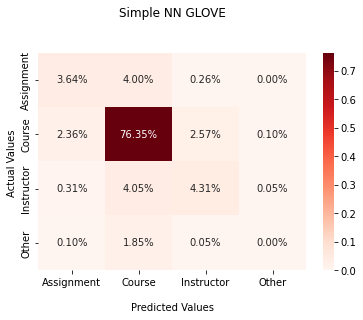

In [ ]:
#test

predict_class_test = [np.argmax(i) for i in model.predict(x_test_glove_scl)]
predictions = model.predict(x_test_glove_scl)

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, predict_class_test)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Reds')

ax.set_title('Simple NN GLOVE\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Assignment', 'Course','Instructor','Other'])
ax.yaxis.set_ticklabels(['Assignment', 'Course','Instructor','Other'])

## Display the vis

LSTM Glove

using keras tokenizer here

In [ ]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(xtrain) + list(xvalid) + list(x_test))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)
x_test_seq = token.texts_to_sequences(x_test)

# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)
x_test_pad = sequence.pad_sequences(x_test_seq, maxlen=max_len)

word_index = token.word_index

In [ ]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 6553/6553 [00:00<00:00, 310694.45it/s]


In [ ]:
# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(4))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, verbose=1, validation_data=(xvalid_pad, yvalid_enc))

In [ ]:
model.summary()
print ("logloss: %0.3f " % multiclass_logloss(yvalid_enc, model.predict(xvalid_pad)))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 70, 300)           1966200   
                                                                 
 spatial_dropout1d (SpatialD  (None, 70, 300)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense_3 (Dense)             (None, 1024)              103424    
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              1049600   
                                                      

In [ ]:
predictions = [np.argmax(i) for i in model.predict(x_test_pad)]

In [ ]:
precision_recall_fscore_support(y_test, predictions, average='weighted')
print('LSTM keras tokenizer\nPrecision =',precision_recall_fscore_support(y_test, predictions, average='weighted')[0])
print('Recall =',precision_recall_fscore_support(y_test, predictions, average='weighted')[1])
print('F1 Score =',precision_recall_fscore_support(y_test, predictions, average='weighted')[2])
#print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions))
print ("logloss: %0.3f " % multiclass_logloss(y_test_enc, model.predict(x_test_pad)))

LSTM keras tokenizer
Precision = 0.848605211953348
Recall = 0.8594150846587993
F1 Score = 0.8521253781665513
logloss: 1.648 


In [ ]:
print ("logloss: %0.3f " % multiclass_logloss(y_test_enc, model.predict(x_test_pad)))

logloss: 1.648 


[Text(0, 0.5, 'Assignment'),
 Text(0, 1.5, 'Course'),
 Text(0, 2.5, 'Instructor'),
 Text(0, 3.5, 'Other')]

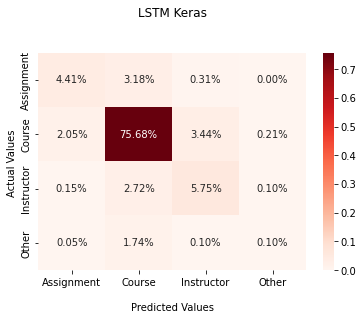

In [ ]:
#test

predict_class_test = [np.argmax(i) for i in model.predict(x_test_pad)]
predictions = model.predict(x_test_pad)

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, predict_class_test)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Reds')

ax.set_title('LSTM Keras\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Assignment', 'Course','Instructor','Other'])
ax.yaxis.set_ticklabels(['Assignment', 'Course','Instructor','Other'])

## Display the vis

LSTM Glove

In [ ]:
EMBEDDING_FILE=f'/content/glove.6B.300d.txt'

In [ ]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

In [ ]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


(-0.0039050116, 0.38177028)

In [ ]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
maxlen = 300
max_features = len(word_index) + 1
embed_size = 300

In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(x)
x = GlobalMaxPool1D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.8)(x)

x = Dense(1024, activation="relu")(x)
x = Dropout(0.8)(x)

x = Dense(4, activation="softmax")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(xtrain_glove_scl, y=ytrain_enc, batch_size=512, epochs=100, verbose=1, 
          validation_data=(xvalid_glove_scl, yvalid_enc))

Epoch 1/100
18/18 [==============================] - 102s 3s/step - loss: 1.3820 - accuracy: 0.2841 - val_loss: 1.3112 - val_accuracy: 0.3924
Epoch 2/100
18/18 [==============================] - 47s 3s/step - loss: 1.2955 - accuracy: 0.3688 - val_loss: 1.2725 - val_accuracy: 0.3763
Epoch 3/100
18/18 [==============================] - 47s 3s/step - loss: 1.2736 - accuracy: 0.3678 - val_loss: 1.2555 - val_accuracy: 0.4135
Epoch 4/100
18/18 [==============================] - 48s 3s/step - loss: 1.2517 - accuracy: 0.3830 - val_loss: 1.2258 - val_accuracy: 0.4205
Epoch 5/100
18/18 [==============================] - 48s 3s/step - loss: 1.2142 - accuracy: 0.4156 - val_loss: 1.1668 - val_accuracy: 0.4366
Epoch 6/100
18/18 [==============================] - 46s 3s/step - loss: 1.1647 - accuracy: 0.4463 - val_loss: 1.1384 - val_accuracy: 0.4718
Epoch 7/100
18/18 [==============================] - 47s 3s/step - loss: 1.1279 - accuracy: 0.4614 - val_loss: 1.0791 - val_accuracy: 0.4930
Epoch 8/100


In [ ]:
predictions = [np.argmax(i) for i in model.predict(x_test_glove_scl)]

In [ ]:
precision_recall_fscore_support(y_test, predictions, average='weighted')
print('LSTM Glove\nPrecision =',precision_recall_fscore_support(y_test, predictions, average='weighted')[0])
print('Recall =',precision_recall_fscore_support(y_test, predictions, average='weighted')[1])
print('F1 Score =',precision_recall_fscore_support(y_test, predictions, average='weighted')[2])
#print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions))
print ("logloss: %0.3f " % multiclass_logloss(y_test_enc, model.predict(x_test_glove_scl)))

LSTM Glove
Precision = 0.7018451345192871
Recall = 0.6582863006670088
F1 Score = 0.6770458800487783
logloss: 1.954 


[Text(0, 0.5, 'Assignment'),
 Text(0, 1.5, 'Course'),
 Text(0, 2.5, 'Instructor'),
 Text(0, 3.5, 'Other')]

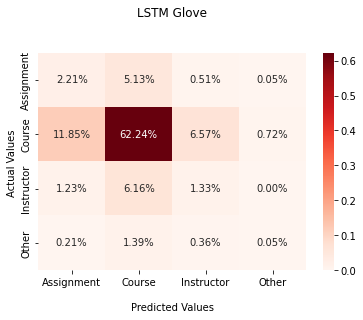

In [ ]:
#test

predict_class_test = [np.argmax(i) for i in model.predict(x_test_glove_scl)]
predictions = model.predict(x_test_glove_scl)

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, predict_class_test)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Reds')

ax.set_title('LSTM Glove\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Assignment', 'Course','Instructor','Other'])
ax.yaxis.set_ticklabels(['Assignment', 'Course','Instructor','Other'])

## Display the vis

In [ ]:
#Early stop
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(x)
x = GlobalMaxPool1D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.8)(x)

x = Dense(1024, activation="relu")(x)
x = Dropout(0.8)(x)

x = Dense(4, activation="softmax")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_glove_scl, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_glove_scl, yvalid_enc), callbacks=[earlystop])

Epoch 1/100
18/18 [==============================] - 89s 5s/step - loss: 1.3786 - accuracy: 0.2901 - val_loss: 1.3141 - val_accuracy: 0.3863
Epoch 2/100
18/18 [==============================] - 47s 3s/step - loss: 1.2989 - accuracy: 0.3654 - val_loss: 1.2691 - val_accuracy: 0.3773
Epoch 3/100
18/18 [==============================] - 46s 3s/step - loss: 1.2710 - accuracy: 0.3802 - val_loss: 1.2568 - val_accuracy: 0.4054
Epoch 4/100
18/18 [==============================] - 48s 3s/step - loss: 1.2489 - accuracy: 0.3948 - val_loss: 1.2191 - val_accuracy: 0.4356
Epoch 5/100
18/18 [==============================] - 47s 3s/step - loss: 1.2046 - accuracy: 0.4276 - val_loss: 1.1725 - val_accuracy: 0.4266
Epoch 6/100
18/18 [==============================] - 46s 3s/step - loss: 1.1710 - accuracy: 0.4457 - val_loss: 1.1370 - val_accuracy: 0.4799
Epoch 7/100
18/18 [==============================] - 75s 4s/step - loss: 1.1341 - accuracy: 0.4670 - val_loss: 1.1245 - val_accuracy: 0.4718
Epoch 8/100
1

In [ ]:
predictions = [np.argmax(i) for i in model.predict(x_test_glove_scl)]
precision_recall_fscore_support(y_test, predictions, average='weighted')
print('LSTM Glove early stop\nPrecision =',precision_recall_fscore_support(y_test, predictions, average='weighted')[0])
print('Recall =',precision_recall_fscore_support(y_test, predictions, average='weighted')[1])
print('F1 Score =',precision_recall_fscore_support(y_test, predictions, average='weighted')[2])
#print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions))
print ("logloss: %0.3f " % multiclass_logloss(y_test_enc, model.predict(x_test_glove_scl)))

LSTM Glove early stop
Precision = 0.6906377648513111
Recall = 0.41046690610569525
F1 Score = 0.49008552293074015
logloss: 1.556 


Bi LSTM Glove

In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable=False)(inp)
x = Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3))(x)
#x = GlobalMaxPool1D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.8)(x)

x = Dense(1024, activation="relu")(x)
x = Dropout(0.8)(x)

x = Dense(4, activation="softmax")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_glove_scl, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_glove_scl, yvalid_enc), callbacks=[earlystop])

Epoch 1/100
18/18 [==============================] - 58s 3s/step - loss: 1.3504 - accuracy: 0.3164 - val_loss: 1.3238 - val_accuracy: 0.3954
Epoch 2/100
18/18 [==============================] - 44s 2s/step - loss: 1.2672 - accuracy: 0.3927 - val_loss: 1.1663 - val_accuracy: 0.4769
Epoch 3/100
18/18 [==============================] - 44s 2s/step - loss: 1.1442 - accuracy: 0.4777 - val_loss: 1.0498 - val_accuracy: 0.5030
Epoch 4/100
18/18 [==============================] - 45s 2s/step - loss: 1.0478 - accuracy: 0.5267 - val_loss: 0.9125 - val_accuracy: 0.5905
Epoch 5/100
18/18 [==============================] - 45s 3s/step - loss: 0.9067 - accuracy: 0.5872 - val_loss: 0.8045 - val_accuracy: 0.6177
Epoch 6/100
18/18 [==============================] - 44s 2s/step - loss: 0.8323 - accuracy: 0.6231 - val_loss: 0.7623 - val_accuracy: 0.6549
Epoch 7/100
18/18 [==============================] - 44s 2s/step - loss: 0.7687 - accuracy: 0.6579 - val_loss: 0.6681 - val_accuracy: 0.7213
Epoch 8/100
1

In [ ]:
predictions = [np.argmax(i) for i in model.predict(x_test_glove_scl)]
precision_recall_fscore_support(y_test, predictions, average='weighted')
print('LSTM Glove early stop\nPrecision =',precision_recall_fscore_support(y_test, predictions, average='weighted')[0])
print('Recall =',precision_recall_fscore_support(y_test, predictions, average='weighted')[1])
print('F1 Score =',precision_recall_fscore_support(y_test, predictions, average='weighted')[2])
#print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions))
print ("logloss: %0.3f " % multiclass_logloss(y_test_enc, model.predict(x_test_glove_scl)))

LSTM Glove early stop
Precision = 0.7206714567773624
Recall = 0.6044125192406362
F1 Score = 0.6499132375153678
logloss: 1.744 


bi-lstm keras glove

In [ ]:
'''# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(4))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')'''

In [ ]:
# A simple bidirectional LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(4))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
'''earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])'''

"earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')\nmodel.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, \n          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])"

In [ ]:
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc))

Epoch 1/100
18/18 [==============================] - 24s 1s/step - loss: 0.0067 - val_loss: 0.2196
Epoch 2/100
18/18 [==============================] - 24s 1s/step - loss: 0.0035 - val_loss: 0.2140
Epoch 3/100
18/18 [==============================] - 12s 662ms/step - loss: 0.0037 - val_loss: 0.1906
Epoch 4/100
18/18 [==============================] - 10s 564ms/step - loss: 0.0035 - val_loss: 0.1973
Epoch 5/100
18/18 [==============================] - 10s 552ms/step - loss: 0.0052 - val_loss: 0.2028
Epoch 6/100
18/18 [==============================] - 10s 559ms/step - loss: 0.0052 - val_loss: 0.1621
Epoch 7/100
18/18 [==============================] - 10s 558ms/step - loss: 0.0048 - val_loss: 0.1815
Epoch 8/100
18/18 [==============================] - 11s 615ms/step - loss: 0.0048 - val_loss: 0.1288
Epoch 9/100
18/18 [==============================] - 10s 559ms/step - loss: 0.0065 - val_loss: 0.2031
Epoch 10/100
18/18 [==============================] - 12s 654ms/step - loss: 0.0026 - va

In [ ]:
predictions = [np.argmax(i) for i in model.predict(x_test_pad)]
precision_recall_fscore_support(y_test, predictions, average='weighted')
print('bi LSTM Glove\nPrecision =',precision_recall_fscore_support(y_test, predictions, average='weighted')[0])
print('Recall =',precision_recall_fscore_support(y_test, predictions, average='weighted')[1])
print('F1 Score =',precision_recall_fscore_support(y_test, predictions, average='weighted')[2])
#print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions))
print ("logloss: %0.3f " % multiclass_logloss(y_test_enc, model.predict(x_test_pad)))

LSTM Glove early stop
Precision = 0.8532671672645598
Recall = 0.8624935864545921
F1 Score = 0.856224509848335
logloss: 1.826 


two layers of GRU

In [ ]:
# GRU with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(4))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

'''# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])'''

"# Fit the model with early stopping callback\nearlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')\nmodel.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, \n          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])"

In [ ]:
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc))

Epoch 1/100
18/18 [==============================] - 41s 2s/step - loss: 1.2880 - val_loss: 0.8682
Epoch 2/100
18/18 [==============================] - 32s 2s/step - loss: 0.8235 - val_loss: 0.5054
Epoch 3/100
18/18 [==============================] - 24s 1s/step - loss: 0.5905 - val_loss: 0.3754
Epoch 4/100
18/18 [==============================] - 12s 641ms/step - loss: 0.4328 - val_loss: 0.2792
Epoch 5/100
18/18 [==============================] - 12s 648ms/step - loss: 0.3306 - val_loss: 0.2312
Epoch 6/100
18/18 [==============================] - 12s 694ms/step - loss: 0.2830 - val_loss: 0.1792
Epoch 7/100
18/18 [==============================] - 12s 659ms/step - loss: 0.2253 - val_loss: 0.1628
Epoch 8/100
18/18 [==============================] - 12s 654ms/step - loss: 0.2053 - val_loss: 0.1393
Epoch 9/100
18/18 [==============================] - 12s 651ms/step - loss: 0.1807 - val_loss: 0.1219
Epoch 10/100
18/18 [==============================] - 12s 653ms/step - loss: 0.1674 - val_l

In [ ]:
predictions = [np.argmax(i) for i in model.predict(x_test_pad)]
precision_recall_fscore_support(y_test, predictions, average='weighted')
print('GRU Glove keras\nPrecision =',precision_recall_fscore_support(y_test, predictions, average='weighted')[0])
print('Recall =',precision_recall_fscore_support(y_test, predictions, average='weighted')[1])
print('F1 Score =',precision_recall_fscore_support(y_test, predictions, average='weighted')[2])
#print ("logloss: %0.3f " % multiclass_logloss(y_test, predictions))
print ("logloss: %0.3f " % multiclass_logloss(y_test_enc, model.predict(x_test_pad)))

GRU Glove keras
Precision = 0.8547377992342549
Recall = 0.8624935864545921
F1 Score = 0.8571003754058378
logloss: 1.803 


In [ ]:
model.summary()
print ("logloss: %0.3f " % multiclass_logloss(yvalid_enc, model.predict(xvalid_pad)))

In [ ]:
# Bidirectional RNN
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))

model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))
#model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(4))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data=(xvalid_pad, yvalid_enc), callbacks=[earlystop])

In [ ]:
model.summary()
print ("logloss: %0.3f " % multiclass_logloss(yvalid_enc, model.predict(xvalid_pad)))

ATTENTION PLEASE

In [ ]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    Encoder for encoding the text into sequence of integers for BERT Input
    """
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [ ]:
#IMP DATA FOR CONFIG

AUTO = tf.data.experimental.AUTOTUNE


# Configuration
EPOCHS = 3
BATCH_SIZE = 32
MAX_LEN = 300

Load Tokenizer

In [ ]:
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

[06:31:23] DEBUG Starting new HTTPS connection (1): huggingface.co:443
[06:31:23] DEBUG https://huggingface.co:443 "HEAD /distilbert-base-multilingual-cased/resolve/main/vocab.txt HTTP/1.1" 200 0
[06:31:23] DEBUG Attempting to acquire lock 139890070013136 on /root/.cache/huggingface/transformers/28e5b750bf4f39cc620367720e105de1501cf36ec4ca7029eba82c1d2cc47caf.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29.lock
[06:31:23] DEBUG Lock 139890070013136 acquired on /root/.cache/huggingface/transformers/28e5b750bf4f39cc620367720e105de1501cf36ec4ca7029eba82c1d2cc47caf.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29.lock
[06:31:23] DEBUG Starting new HTTPS connection (1): huggingface.co:443
[06:31:24] DEBUG https://huggingface.co:443 "GET /distilbert-base-multilingual-cased/resolve/main/vocab.txt HTTP/1.1" 200 995526


Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

[06:31:24] DEBUG Attempting to release lock 139890070013136 on /root/.cache/huggingface/transformers/28e5b750bf4f39cc620367720e105de1501cf36ec4ca7029eba82c1d2cc47caf.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29.lock
[06:31:24] DEBUG Lock 139890070013136 released on /root/.cache/huggingface/transformers/28e5b750bf4f39cc620367720e105de1501cf36ec4ca7029eba82c1d2cc47caf.6c5b6600e968f4b5e08c86d8891ea99e51537fc2bf251435fb46922e8f7a7b29.lock
[06:31:24] DEBUG Starting new HTTPS connection (1): huggingface.co:443
[06:31:24] DEBUG https://huggingface.co:443 "HEAD /distilbert-base-multilingual-cased/resolve/main/added_tokens.json HTTP/1.1" 404 0
[06:31:24] DEBUG Starting new HTTPS connection (1): huggingface.co:443
[06:31:25] DEBUG https://huggingface.co:443 "HEAD /distilbert-base-multilingual-cased/resolve/main/special_tokens_map.json HTTP/1.1" 404 0
[06:31:25] DEBUG Starting new HTTPS connection (1): huggingface.co:443
[06:31:25] DEBUG https://huggingface.co:443 "HEAD /disti

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

[06:31:25] DEBUG Attempting to release lock 139890074902672 on /root/.cache/huggingface/transformers/47087d99feeb3bc6184d7576ff089c52f7fbe3219fe48c6c4fa681e617753256.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f.lock
[06:31:25] DEBUG Lock 139890074902672 released on /root/.cache/huggingface/transformers/47087d99feeb3bc6184d7576ff089c52f7fbe3219fe48c6c4fa681e617753256.ec5c189f89475aac7d8cbd243960a0655cfadc3d0474da8ff2ed0bf1699c2a5f.lock
[06:31:25] DEBUG Starting new HTTPS connection (1): huggingface.co:443
[06:31:26] DEBUG https://huggingface.co:443 "HEAD /distilbert-base-multilingual-cased/resolve/main/config.json HTTP/1.1" 200 0
[06:31:26] DEBUG Attempting to acquire lock 139890035812816 on /root/.cache/huggingface/transformers/cf37a9dc282a679f121734d06f003625d14cfdaf55c14358c4c0b8e7e2b89ac9.7a727bd85e40715bec919a39cdd6f0aba27a8cd488f2d4e0f512448dcd02bf0f.lock
[06:31:26] DEBUG Lock 139890035812816 acquired on /root/.cache/huggingface/transformers/cf37a9dc282a679f121

Downloading:   0%|          | 0.00/466 [00:00<?, ?B/s]

[06:31:26] DEBUG Attempting to release lock 139890035812816 on /root/.cache/huggingface/transformers/cf37a9dc282a679f121734d06f003625d14cfdaf55c14358c4c0b8e7e2b89ac9.7a727bd85e40715bec919a39cdd6f0aba27a8cd488f2d4e0f512448dcd02bf0f.lock
[06:31:26] DEBUG Lock 139890035812816 released on /root/.cache/huggingface/transformers/cf37a9dc282a679f121734d06f003625d14cfdaf55c14358c4c0b8e7e2b89ac9.7a727bd85e40715bec919a39cdd6f0aba27a8cd488f2d4e0f512448dcd02bf0f.lock


Tokenizer(vocabulary_size=119547, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=False, wordpieces_prefix=##)

In [ ]:
df

,Unnamed,sentence,class,class_num
0,2189,working with jupyter workspace and ibm cloud w...,other,4
1,1880,i had my degree in mathematics in from a uni...,other,4
2,1371,seriously,other,4
3,2587,hope it helps you get better,other,4
4,6853,i am basically a noob at programming,other,4
...,...,...,...,...
9927,7032,a very handson course,course,1
9928,3887,well structured course with clear and compelli...,course,1
9929,4025,taking this course opened a pandoras box of th...,course,1
9930,5424,it was quite easy to understand since i have s...,course,1


In [ ]:
x_train = fast_encode(train1.comment_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_valid = fast_encode(valid.comment_text.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_test = fast_encode(test.content.astype(str), fast_tokenizer, maxlen=MAX_LEN)

y_train = train1.toxic.values
y_valid = valid.toxic.values

Ensembling

In [ ]:
# this is the main ensembling class. how to use it is in the next cell!
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
import pandas as pd
import os
import sys
import logging

logging.basicConfig(
    level=logging.DEBUG,
    format="[%(asctime)s] %(levelname)s %(message)s",
    datefmt="%H:%M:%S", stream=sys.stdout)
logger = logging.getLogger(__name__)


class Ensembler(object):
    def __init__(self, model_dict, num_folds=3, task_type='classification', optimize=roc_auc_score,
                 lower_is_better=False, save_path=None):
        """
        Ensembler init function
        :param model_dict: model dictionary, see README for its format
        :param num_folds: the number of folds for ensembling
        :param task_type: classification or regression
        :param optimize: the function to optimize for, e.g. AUC, logloss, etc. Must have two arguments y_test and y_pred
        :param lower_is_better: is lower value of optimization function better or higher
        :param save_path: path to which model pickles will be dumped to along with generated predictions, or None
        """

        self.model_dict = model_dict
        self.levels = len(self.model_dict)
        self.num_folds = num_folds
        self.task_type = task_type
        self.optimize = optimize
        self.lower_is_better = lower_is_better
        self.save_path = save_path

        self.training_data = None
        self.test_data = None
        self.y = None
        self.lbl_enc = None
        self.y_enc = None
        self.train_prediction_dict = None
        self.test_prediction_dict = None
        self.num_classes = None

    def fit(self, training_data, y, lentrain):
        """
        :param training_data: training data in tabular format
        :param y: binary, multi-class or regression
        :return: chain of models to be used in prediction
        """

        self.training_data = training_data
        self.y = y

        if self.task_type == 'classification':
            self.num_classes = len(np.unique(self.y))
            logger.info("Found %d classes", self.num_classes)
            self.lbl_enc = LabelEncoder()
            self.y_enc = self.lbl_enc.fit_transform(self.y)
            kf = StratifiedKFold(n_splits=self.num_folds)
            train_prediction_shape = (lentrain, self.num_classes)
        else:
            self.num_classes = -1
            self.y_enc = self.y
            kf = KFold(n_splits=self.num_folds)
            train_prediction_shape = (lentrain, 1)

        self.train_prediction_dict = {}
        for level in range(self.levels):
            self.train_prediction_dict[level] = np.zeros((train_prediction_shape[0],
                                                          train_prediction_shape[1] * len(self.model_dict[level])))

        for level in range(self.levels):

            if level == 0:
                temp_train = self.training_data
            else:
                temp_train = self.train_prediction_dict[level - 1]

            for model_num, model in enumerate(self.model_dict[level]):
                validation_scores = []
                foldnum = 1
                for train_index, valid_index in kf.split(self.train_prediction_dict[0], self.y_enc):
                    logger.info("Training Level %d Fold # %d. Model # %d", level, foldnum, model_num)

                    if level != 0:
                        l_training_data = temp_train[train_index]
                        l_validation_data = temp_train[valid_index]
                        model.fit(l_training_data, self.y_enc[train_index])
                    else:
                        l0_training_data = temp_train[0][model_num]
                        if type(l0_training_data) == list:
                            l_training_data = [x[train_index] for x in l0_training_data]
                            l_validation_data = [x[valid_index] for x in l0_training_data]
                        else:
                            l_training_data = l0_training_data[train_index]
                            l_validation_data = l0_training_data[valid_index]
                        model.fit(l_training_data, self.y_enc[train_index])

                    logger.info("Predicting Level %d. Fold # %d. Model # %d", level, foldnum, model_num)

                    if self.task_type == 'classification':
                        temp_train_predictions = model.predict_proba(l_validation_data)
                        self.train_prediction_dict[level][valid_index,
                        (model_num * self.num_classes):(model_num * self.num_classes) +
                                                       self.num_classes] = temp_train_predictions

                    else:
                        temp_train_predictions = model.predict(l_validation_data)
                        self.train_prediction_dict[level][valid_index, model_num] = temp_train_predictions
                    validation_score = self.optimize(self.y_enc[valid_index], temp_train_predictions)
                    validation_scores.append(validation_score)
                    logger.info("Level %d. Fold # %d. Model # %d. Validation Score = %f", level, foldnum, model_num,
                                validation_score)
                    foldnum += 1
                avg_score = np.mean(validation_scores)
                std_score = np.std(validation_scores)
                logger.info("Level %d. Model # %d. Mean Score = %f. Std Dev = %f", level, model_num,
                            avg_score, std_score)

            logger.info("Saving predictions for level # %d", level)
            train_predictions_df = pd.DataFrame(self.train_prediction_dict[level])
            train_predictions_df.to_csv(os.path.join(self.save_path, "train_predictions_level_" + str(level) + ".csv"),
                                        index=False, header=None)

        return self.train_prediction_dict

    def predict(self, test_data, lentest):
        self.test_data = test_data
        if self.task_type == 'classification':
            test_prediction_shape = (lentest, self.num_classes)
        else:
            test_prediction_shape = (lentest, 1)

        self.test_prediction_dict = {}
        for level in range(self.levels):
            self.test_prediction_dict[level] = np.zeros((test_prediction_shape[0],
                                                         test_prediction_shape[1] * len(self.model_dict[level])))
        self.test_data = test_data
        for level in range(self.levels):
            if level == 0:
                temp_train = self.training_data
                temp_test = self.test_data
            else:
                temp_train = self.train_prediction_dict[level - 1]
                temp_test = self.test_prediction_dict[level - 1]

            for model_num, model in enumerate(self.model_dict[level]):

                logger.info("Training Fulldata Level %d. Model # %d", level, model_num)
                if level == 0:
                    model.fit(temp_train[0][model_num], self.y_enc)
                else:
                    model.fit(temp_train, self.y_enc)

                logger.info("Predicting Test Level %d. Model # %d", level, model_num)

                if self.task_type == 'classification':
                    if level == 0:
                        temp_test_predictions = model.predict_proba(temp_test[0][model_num])
                    else:
                        temp_test_predictions = model.predict_proba(temp_test)
                    self.test_prediction_dict[level][:, (model_num * self.num_classes): (model_num * self.num_classes) +
                                                                                        self.num_classes] = temp_test_predictions

                else:
                    if level == 0:
                        temp_test_predictions = model.predict(temp_test[0][model_num])
                    else:
                        temp_test_predictions = model.predict(temp_test)
                    self.test_prediction_dict[level][:, model_num] = temp_test_predictions

            test_predictions_df = pd.DataFrame(self.test_prediction_dict[level])
            test_predictions_df.to_csv(os.path.join(self.save_path, "test_predictions_level_" + str(level) + ".csv"),
                                       index=False, header=None)

        return self.test_prediction_dict

In [ ]:
# specify the data to be used for every level of ensembling:
train_data_dict = {0: [xtrain_tfv, xtrain_ctv, xtrain_tfv, xtrain_ctv], 1: [xtrain_glove]}
test_data_dict = {0: [xvalid_tfv, xvalid_ctv, xvalid_tfv, xvalid_ctv], 1: [xvalid_glove]}

model_dict = {0: [LogisticRegression(), LogisticRegression(), MultinomialNB(alpha=0.1), MultinomialNB()],

              1: [xgb.XGBClassifier(silent=True, n_estimators=120, max_depth=7)]}

ens = Ensembler(model_dict=model_dict, num_folds=3, task_type='classification',
                optimize=multiclass_logloss, lower_is_better=True, save_path='')

ens.fit(train_data_dict, ytrain, lentrain=xtrain_glove.shape[0])
preds = ens.predict(test_data_dict, lentest=xvalid_glove.shape[0])

[04:35:57] INFO Found 4 classes
[04:35:57] INFO Training Level 0 Fold # 1. Model # 0
[04:35:59] INFO Predicting Level 0. Fold # 1. Model # 0
[04:35:59] INFO Level 0. Fold # 1. Model # 0. Validation Score = 0.240781
[04:35:59] INFO Training Level 0 Fold # 2. Model # 0
[04:36:00] INFO Predicting Level 0. Fold # 2. Model # 0
[04:36:00] INFO Level 0. Fold # 2. Model # 0. Validation Score = 0.256096
[04:36:00] INFO Training Level 0 Fold # 3. Model # 0
[04:36:01] INFO Predicting Level 0. Fold # 3. Model # 0
[04:36:01] INFO Level 0. Fold # 3. Model # 0. Validation Score = 0.242527
[04:36:01] INFO Level 0. Model # 0. Mean Score = 0.246468. Std Dev = 0.006845
[04:36:01] INFO Training Level 0 Fold # 1. Model # 1
[04:36:03] INFO Predicting Level 0. Fold # 1. Model # 1
[04:36:03] INFO Level 0. Fold # 1. Model # 1. Validation Score = 0.085477
[04:36:03] INFO Training Level 0 Fold # 2. Model # 1
[04:36:05] INFO Predicting Level 0. Fold # 2. Model # 1
[04:36:05] INFO Level 0. Fold # 2. Model # 1. Val

In [ ]:
# check error:
multiclass_logloss(yvalid, preds[1])

0.0010963031464944792